# Densenet121 Pre trained to test

This jupyter notebook has the objective to, not only retrieve the accuracies of the Densenet121 pretrained, but to obtain also <br>
the layer features before the last classification layer.

In [28]:
 #Import necessary modules
import os
import torch

import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from dotenv import load_dotenv
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

### Set the path to here

Make sure the setup the paths properly!

In [29]:
#Path to assign tests (copy path directly)
notebooks_path = os.getcwd() # OR MAYBE has to be set manually depending your computer

#Set the path to this working directory
os.chdir(notebooks_path)
print(os.getcwd())

import sys
#Append the path the src folder
sys.path.append(os.path.join(os.getcwd(), os.pardir, "src"))

/Users/abhishekkumar/Projects/cs231n/CS231N-Final-Proj/notebooks


### Import the necessary module for downloading

Note for this: EVERYTIME There is a change inside the download <br>
the changes inside the file would only be shown if the jupyter kernel is restarted. <br>


In [30]:
# Import the necessary modules
from utils import CXReader, DfReader

### Set the data path

In [31]:
# Create the data path
df_path = os.path.join(notebooks_path, os.pardir, "meta")

# If the environment is defined, prefer that over the local path
if "DATA_PATH" in os.environ:
    data_path = os.environ["DATA_PATH"]
data_path = data_path or os.path.join(df_path, "images")
print(f'df_path: {df_path}, \ndata_path: {data_path}')

df_path: /Users/abhishekkumar/Projects/cs231n/CS231N-Final-Proj/notebooks/../meta, 
data_path: /Users/abhishekkumar/Projects/cs231n/cxr14/images


### Get the dataframes of the data
First, lets obtain the dataframes for the data and check that all metadata <br>
information has been set up properly. <br>

In [32]:
#Create a dataframe compiler
df_compiler = DfReader()

#set the path and retrieve the dataframes
df_compiler.set_folder_path(df_path)

#Get the dataframe holder and names
dfs_holder, dfs_names = df_compiler.get_dfs()

100%|██████████| 4/4 [00:00<00:00, 37.81it/s]

The file: val.csv has been retrieved
The file: test.csv has been retrieved
The file: train.csv has been retrieved


# Read the images and labels

Also, obtain DataLoaders for test, train, and validation datasets using <br>
the Dataloader class from pytorch.

In [33]:
print(torch.cuda.is_available())

False


In [34]:
# Get the device if cuda or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define a transformations for the VGGnet16 (requires a 224,224)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.CenterCrop((224, 224)),  # Center crop to 224x224
    transforms.ToTensor(),
])

#Create datasets and dataloaders
train_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[dfs_names.index('train.csv')], transform=transform,device=device)
test_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[dfs_names.index('test.csv')], transform=transform, device=device)
val_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[dfs_names.index('val.csv')], transform=transform, device=device)

#Sampled images from train to see single shape
sample_image, sample_label = train_dataset[1]
print("====Dataset Information====")
print("Total training samples", len(train_dataset))
print("Total training samples", len(test_dataset))
print("Total training samples", len(val_dataset))
print("====Dataset Information====\n\n")
print("====Sample Data====")
print(f"Image: {sample_image.shape}, labels: {sample_label.shape}")
print("====Sample Data====\n\n")

# With batch size of 32, and shuffle true, and num workers = 4
batch_size = 32

# Set the number of workers on local machine to be 0 for debugging
if os.environ.get("NUM_WORKERS"):
    num_workers = int(os.environ.get("NUM_WORKERS"))
else:
    num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#Iterate inside a batch
for idx, batch in enumerate(train_loader):
    print(f"batch number: {idx}")
    images, labels = batch
    print("Shape of batch of images and labels")
    print(f"Images: {images.shape}, labels: {labels.shape}")
    if idx == 5:
        print("It can iterate through all batches")
        break

====Dataset Information====
Total training samples 78506
Total training samples 21081
Total training samples 12533
====Dataset Information====


====Sample Data====
Image: torch.Size([3, 224, 224]), labels: torch.Size([15])
====Sample Data====


batch number: 0
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 15])
batch number: 1
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 15])
batch number: 2
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 15])
batch number: 3
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 15])
batch number: 4
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 15])
batch number: 5
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 15])
It can iterate through all batches

### Load the densenet121 pretrained model

Check if you have GPU Envidia! Else, use the cpu

In [35]:
#Load the pretrained model
densenet121 = models.densenet121(weights='DEFAULT')

### See the densenet121.features architecture and get the parameter shapes

In [36]:
print(densenet121.features)
print([x.shape for x in densenet121.features.parameters()])

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

### See the densenet121 classifier parameters and weights

In [37]:
print(densenet121.classifier)
print([x.shape for x in densenet121.classifier.parameters()])

Linear(in_features=1024, out_features=1000, bias=True)
[torch.Size([1000, 1024]), torch.Size([1000])]


In [38]:
# NEW CODE CELL to conduct fine-tuning on Vggnet16 only on the last (Linear) layer

# First, freeze all the parameters
for param in densenet121.parameters():
    param.requires_grad = False

In [39]:
# Modify the last layer for the last 20 classes
num_classes = sample_label.shape[0]  # Number of classes for your specific task
num_features = densenet121.classifier.in_features #Get all of the features after convolutional layers

print(num_classes)
print(num_features)

15
1024


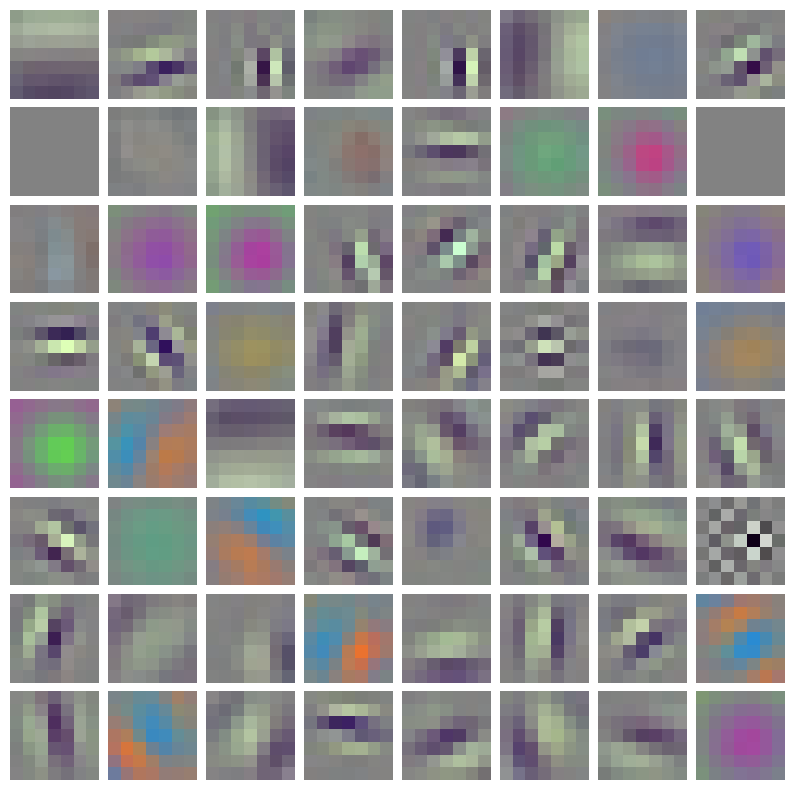

In [40]:
from utils.plot import visualise_weights

# visualise the weights of the first layer
weights = densenet121.features.conv0.weight.data.cpu().numpy()
visualise_weights(weights)

In [41]:
# Obtain the same classifier you got befor with lower number of classes, so we can pretrain it
# Since we are using cross entropy loss, we don't need to add an activation at the end
dropout_p = 0.1
densenet121.classifier = nn.Sequential(
    nn.Linear(num_features, 4096, bias=True),
    nn.ReLU(inplace= True),
    nn.Dropout(dropout_p, inplace=False),
    nn.Linear(4096, 4096, bias=True),
    nn.ReLU(inplace= True),
    nn.Dropout(dropout_p, inplace=False),
    nn.Linear(4096, num_classes, bias=True)
)

print(densenet121.classifier)

Sequential(
  (0): Linear(in_features=1024, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=4096, out_features=15, bias=True)
)


In [42]:
# Create state_dict path
model_dict_path = os.path.join(notebooks_path, os.pardir, "models")

if os.path.exists(model_dict_path) == False:
    os.mkdir(model_dict_path)
print(model_dict_path)

/Users/abhishekkumar/Projects/cs231n/CS231N-Final-Proj/notebooks/../models


In [43]:
# Loss Function
# Create the weights for the loss function
# The weights are the inverse of the class frequency
# This is to account for the class imbalance
# Lets get the frequencies of the classes in the training set
train_df = dfs_holder[dfs_names.index('train.csv')]
class_frequencis = torch.tensor(train_df[train_df.columns[1:-1]].sum().values)
weights = 1.0 / class_frequencis
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weights)

In [44]:
# Optimiser
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = densenet121

# we are updating the below parameters
for i, layer in enumerate(model.classifier.children()):
    print(f"Layer {i}: {layer.__class__.__name__}")
    for name, param in layer.named_parameters():
        print(f"  {name}: {param.size()}")

optimizer = Adam(model.classifier.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)


Layer 0: Linear
  weight: torch.Size([4096, 1024])
  bias: torch.Size([4096])
Layer 1: ReLU
Layer 2: Dropout
Layer 3: Linear
  weight: torch.Size([4096, 4096])
  bias: torch.Size([4096])
Layer 4: ReLU
Layer 5: Dropout
Layer 6: Linear
  weight: torch.Size([15, 4096])
  bias: torch.Size([15])


In [45]:
use_wandb = bool(os.environ.get('USE_WANDB', False))
if use_wandb:
    import wandb

In [46]:
threshold = 0.5
def convert_scores_to_class_predictions(scores):
    # ToDo: The class scores need to be converted to class predictions
    # predict labels
    # labels = (scores > threshold).float()
    # return labels
    pass


In [47]:
def val_accuracy(loader, model):
    # ToDo: add train flag in the dataset
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            labels = labels.to(device=device, dtype=torch.float32)
            scores = model(images)

            labels = convert_scores_to_class_predictions(scores)

            # ToDo: Determine a method to convert the scores to class predictions
        #     _, preds = scores.max(1)
        #     num_correct += (preds == y).sum()
        #     num_samples += preds.size(0)
        # acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    # return acc

In [50]:
def finetune_model(model, data_loader, num_epochs, device:str):
    # Initialize wandb
    if use_wandb:
        wandb.init(
            project="cs231-project", 
            name="densenet121-finetune-adam",
            config={
                "optimizer": "Adam",
                "lr": 0.001,
                "batch_size": 16,
                "num_classes": 14,
                "dropout_p": 0.1
            }
        )

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-------------')
            
        for t, (images, labels) in enumerate(data_loader):

            # Convert labels to float type (also need to move to CUDA again!)
            labels = labels.to(device, dtype=torch.float32)
            images = images.to(device, dtype=torch.float32)

            model = densenet121.to(device)
            model.train()
            
            # forward pass
            scores = model(images)

            # compute loss
            loss = criterion(scores, labels)

            # zero out gradients
            optimizer.zero_grad()
            
            # ToDo: Plot the evaluation matrix like confusion matrix, ROC curve, etc.
            
            # pred_labels = convert_scores_to_class_predictions(scores)

            # # Calculate TP, FP, TN, FN and accuracy
            # TP = torch.sum((pred_labels == 1) & (labels == 1)).item()
            # FP = torch.sum((pred_labels == 1) & (labels == 0)).item()
            # TN = torch.sum((pred_labels == 0) & (labels == 0)).item()
            # FN = torch.sum((pred_labels == 0) & (labels == 1)).item()
            # accuracy = ((TP + TN) / (TP + FP + TN + FN)) * 100.0                

            loss.backward()
            optimizer.step()

            # ToDo: Once figure out a way to get the validation score, also step the scheduler

            wandb.log({"train_loss": loss.item()})

            if t % 1 == 0:
                print('Epoch: {}, Iteration {}, Loss: {}'.format(epoch, t, loss.item()))
                
        
        # Save parameters for each epoch
        torch.save(model.state_dict(), os.path.join(model_dict_path, "densenet121_finetune_params.pth"))

In [51]:
# Let's do fine-tuning
finetune_model(model=model, data_loader=train_loader, num_epochs=5, device=device)

train_loss,▄█▅▃▃▁
train_loss,0.04744


Epoch 1/5
-------------
Epoch: 0, Iteration 0, Loss: 0.06285861134529114
Epoch: 0, Iteration 1, Loss: 0.10713343322277069
Epoch: 0, Iteration 2, Loss: 0.08035506308078766
Epoch: 0, Iteration 3, Loss: 0.07719867676496506
Epoch: 0, Iteration 4, Loss: 0.06268274039030075
Epoch: 0, Iteration 5, Loss: 0.07041128724813461
Epoch: 0, Iteration 6, Loss: 0.10537498444318771
Epoch: 0, Iteration 7, Loss: 0.08273983746767044
Epoch: 0, Iteration 8, Loss: 0.07018682360649109
Epoch: 0, Iteration 9, Loss: 0.047560326755046844
Epoch: 0, Iteration 10, Loss: 0.09859970211982727
Epoch: 0, Iteration 11, Loss: 0.07644838094711304
Epoch: 0, Iteration 12, Loss: 0.09998077899217606
Epoch: 0, Iteration 13, Loss: 0.06319418549537659
Epoch: 0, Iteration 14, Loss: 0.04194164648652077
Epoch: 0, Iteration 15, Loss: 0.06961403042078018
Epoch: 0, Iteration 16, Loss: 0.03803012892603874
Epoch: 0, Iteration 17, Loss: 0.07262994349002838
Epoch: 0, Iteration 18, Loss: 0.01733304187655449
Epoch: 0, Iteration 19, Loss: 0.115

KeyboardInterrupt: 

In [ ]:
densenet121.load_state_dict(torch.load(os.path.join(model_dict_path, "vgg16_finetune_params.pth")))

<All keys matched successfully>

### Create a function that would evaluate the model.

Make sure it outputs all of the accuracies of all 20 conditions. <br>

In [ ]:
import torch.nn.functional as F

def evaluate_model(model, data_loader, limit:int, device:str):
    """
    Instance method that would evaluate with a given
    data loader, the accuracies obtained by the VGGNET16
    """
    model.eval()
    threshold = 0.5
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    #Use no grad to not perform backpropagation for inference time
    with torch.no_grad():
        #Iterate through each of the images and labels
        
        # Calculate the total numbers for metrics
        TP, FP, TN, FN = 0.0, 0.0, 0.0, 0.0
        for idx, batch in enumerate(data_loader):
    
            #See if it works
            images_inputs, images_labels = batch
            images_inputs, images_labels = images_inputs.to(device), images_labels.to(device)

            #Print the shape of each one of them
            print(f"Inputs shape: {images_inputs.shape}, Labels shape: {labels.shape}")

            #Send the outputs to model in device
            outputs = model(images_inputs)

            #Binarize the output with threshold
            pred_labels = (outputs > threshold).float()

            # Calculate batch-wise TP, FP, TN, FN
            b_TP = torch.sum((pred_labels == 1) & (images_labels == 1)).item()
            b_FP = torch.sum((pred_labels == 1) & (images_labels == 0)).item()
            b_TN = torch.sum((pred_labels == 0) & (images_labels == 0)).item()
            b_FN = torch.sum((pred_labels == 0) & (images_labels == 1)).item()
            TP += b_TP
            FP += b_FP
            TN += b_TN
            FN += b_FN

        #_, predicted = torch.max(outputs, 1)  # Get the index of the maximum log-probability
        accuracy = ((TP + TN) / (TP + FP + TN + FN)) * 100.0
        precision = (TP / (TP + FP)) * 100.0 if (TP + FP) > 0 else 0.0
        recall = (TP / (TP + FN)) * 100.0 if (TP + FN) > 0 else 0.0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        print("Accuracy: {:.2f}%".format(accuracy))
        print("Precision: {:.2f}%".format(precision))
        print("Recall: {:.2f}%".format(recall))
        print("F1 Score: {:.2f}%".format(f1_score))

            # accuracies.append(accuracy)
            # precisions.append(precision)
            # recalls.append(recall)
            # f1_scores.append(f1_score)

            # if idx == limit:
            #     print("Limit reached")
            #     break
    return accuracies, precisions, recalls, f1_scores

In [ ]:
# Evaluate on the eval set
accuracies, precisions, recalls, f1_scores = evaluate_model(model, test_loader, 5, device=device)

Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 22